## Frames of the base case's bottom concentration

In [52]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import matplotlib as mpl
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [53]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be at least 2D arrays in coordinate order (..., Y , X ) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...,:,:]) + beta*(S[...,:,:]))
    return rho

def call_unstag(t):
    UU,VV = rout.unstagger(state.U.isel(T=t),state.V.isel(T=t))
    return(UU,VV)


def call_rho(t,yslice,xslice):
    T = state.Temp.isel(T=t,Y=yslice,X=xslice)
    S = state.S.isel(T=t,Y=yslice,X=xslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 


In [54]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaShelf(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx). 
       Conc = cocetration near bottom (nt,ny,nx)
       Area = 2D array of cell areas on shelf (ny,nx)
       NOTE: Everything below the canyon rim is masked out'''
    
    ConcArea = np.empty((19,360,360))
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((19,360,360))
    
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        for j in range(360):
            for i in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                if TrBottom > 0.0:
                    ConcArea[tt,i,j] = TrBottom*ra[i,j]
                    Conc[tt,i,j] = TrBottom
                    Area[tt,i,j] = ra[i,j]
                else:
                    ConcArea[tt,i,j] = np.NaN
                    Conc[tt,i,j] = np.NaN
                    Area[tt,i,j] = np.NaN
                
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    print(np.shape(ConcArea))
    
    maskShelf = np.ma.masked_invalid(ConcFiltered) 
    
    return (np.ma.masked_invalid(ConcArea),
            np.ma.masked_invalid(ConcFiltered),
            np.ma.masked_invalid(Area),
            BottomInd)

In [55]:
# Cross-shelf velocity, Plot1
def Plot1(gs_ax,t,Tr_slice,zslice,yind,xslice,Trmin=0,Trmax=2): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in x-z (nt,nz,nx)
       tslice: advective phase slice to average over.
       yind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    
    Trplot = np.ma.array(Tr_slice.isel(T=t).data/Tr_slice.isel(T=0).data,mask=MaskC[:,yind])
    mesh = ax.contourf(grid.X[xslice]/1000,grid.Z[zslice],Trplot[zslice,xslice],
                       csU,
                       cmap=cmap_name)
    
    #if t == 0:
    cax,kw = mpl.colorbar.make_axes([ax],location='right',anchor=(1.7,0.0),shrink=1.0)
    cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(Trmin, Trmax,8) ],format='%.1f',**kw)
    

    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.set_ylabel('Depth (m)',labelpad=0.3)
    
    ax.text(1.3,0.3,'Tracer concentration \n (non-dim) \n \n Day %1.1f'%(t/2.),fontsize=12,transform=ax.transAxes)
    

In [75]:
# Cross-shelf velocity, Plot1
def Plot1anom(gs_ax,t,Tr_slice,Tr_sliceNoC,zslice,yind,xslice,Trmin=-2,Trmax=2): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in x-z (nt,nz,nx)
       tslice: advective phase slice to average over.
       yind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    
    Trplot = np.ma.array((Tr_slice.isel(T=t).data-Tr_sliceNoC.isel(T=t).data)/(Tr_slice.isel(T=0).data),
                         mask=MaskCNoC[:,yind,:])
    mesh = ax.contourf(grid.X[xslice]/1000,grid.Z[zslice],Trplot[zslice,xslice],
                       #[-1,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,.2,.3,.4,.5,.6,0.7,0.8,0.9], #tracer
                       [-0.4,-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05, 0,0.05,0.1,0.15,.2,0.25,.3,0.35,.4], #oxygen
                       cmap=cmap_name)
    if t == 1:
        cax,kw = mpl.colorbar.make_axes([ax],location='right',anchor=(1.5,0.0),shrink=1.0)
        cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(Trmin, Trmax,8) ],format='%.1f',**kw)

    
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.text(1.3,0.2,'Tracer concentration \n anomaly \n (non-dim) \n \n Day %1.1f'%(t/2.),fontsize=14,transform=ax.transAxes)
    

In [57]:

def Plot2(gs_ax,t,Tr_slice,yslice,zslice,xind,Trmin=0,Trmax=2): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in y-z (nt,nz,ny)
       tslice: advective phase slice to average over.
       xind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    
    Trplot = np.ma.array(Tr_slice.isel(T=t).data/Tr_slice.isel(T=0).data,mask=MaskC[:,:,xind])
    mesh = ax.contourf(grid.Y[yslice]/1000,grid.Z[zslice],(Trplot[zslice,yslice]),
                       csU,
                       cmap=cmap_name)
    
    
    #CS = ax.contour(grid.Y[yslice]/1000,grid.Z[zslice],
    #                (Trplot[zslice,yslice]),
    #                csU2,
    #                colors='k',
    #                linewidths=[0.75] )
    
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.set_xlabel('Cross-shelf distance (km)',labelpad=0.3)
    

In [74]:
def Plot2anom(gs_ax,t,Tr_slice,Tr_sliceNoC,yslice,zslice,xind,Trmin=-2,Trmax=2): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in y-z (nt,nz,ny)
       tslice: advective phase slice to average over.
       xind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    
    csU = np.linspace(Trmin,Trmax,num=31)
    
    Trplot = np.ma.array((Tr_slice.isel(T=t).data-Tr_sliceNoC.isel(T=t).data)/(Tr_slice.isel(T=0).data),
                         mask=MaskCNoC[:,:,xind])
    mesh = ax.contourf(grid.Y[yslice]/1000,grid.Z[zslice],(Trplot[zslice,yslice]),
                       #[-1,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,.2,.3,.4,.5,.6,.7,.8,.9,1], #tracer
                       [-0.4,-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05, 0,0.05,0.1,0.15,.2,0.25,.3,0.35,.4], #oxygen
                       cmap=cmap_name)
    
     
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.set_xlabel('Cross-shelf distance (km)',labelpad=0.3)
    

In [59]:
def Plot3(gs_ax,t,ConcFilt,xslice,yslice,xind,yind,minCM=0,maxCM=2):
    
    ax = plt.subplot(gs_ax)
    BAC = ConcFilt[t,yslice,xslice]
    BAC0 = ConcFilt[0,yslice,xslice]
    
    maxCM = 2
    minCM = 0
    
    mesh = ax.contourf(grid.X[xslice]/1000,grid.Y[yslice]/1000,BAC[:,:]/BAC0[:,:],
                       21, 
                      vmax=maxCM, 
                      vmin=minCM,
                      cmap=cmap_name2)
    
       
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    
    ax.text(0.02,0.9,'Shelf bottom',transform=ax.transAxes,color='w')
    SB = ax.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,
                     grid.Depth[yslice,xslice],
                    [50,75,100,125,150,200,250,300,350,400,450,500],
                    colors=['0.5','0.5','0.5','0.5','0.1','0.5','0.5','0.5','0.5','0.5','0.5','0.5'],
                    linewidths=[0.75] )
    
    
    ax.axhline(grid.Y[yind]/1000,color='k',linestyle='--')
    ax.axvline(grid.X[xind]/1000,color='k',linestyle='--')
    ax.set_aspect(1)
    ax.set_xlabel('Alongshelf distance (km)',labelpad=0.3)
    ax.set_ylabel('Cross-shelf distance (km)',labelpad=0.3)

In [73]:
def Plot3anom(gs_ax,t,ConcFilt,ConcFiltNoC,xslice,yslice,xind,yind,minCM,maxCM):
    
    ax = plt.subplot(gs_ax)
    
    BAC = ConcFilt[t,yslice,xslice]-ConcFiltNoC[t,yslice,xslice]
    BAC0 = ConcFilt[0,yslice,xslice]
    
    mesh = ax.contourf(grid.X[xslice]/1000,grid.Y[yslice]/1000,BAC[:,:]/BAC0[:,:], 
                      #[-1,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,.2,.3,.4,.5,.6,.7,.8,.9,1],# tracer
                       [-0.4,-0.35,-0.3,-0.25,-0.2,-0.15,-0.1,-0.05, 0,0.05,0.1,0.15,.2,0.25,.3,0.35,.4], #oxygen
                      cmap=cmap_name)
       
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    
    ax.text(0.02,0.9,'Shelf Bottom',transform=ax.transAxes)
    SB = ax.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,
                     grid.Depth[yslice,xslice],
                    [150.0],
                    colors=['0.1'],
                    linewidths=[0.75] )
    
    ax.axhline(grid.Y[yind]/1000,color='k',linestyle='--')
    ax.axvline(grid.X[xind]/1000,color='k',linestyle='--')
    ax.set_aspect(1)
    ax.set_xlabel('Alongshelf distance (km)',labelpad=0.3)
    ax.set_ylabel('Cross-shelf distance (km)',labelpad=0.3)

In [64]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/gridGlob.nc'
grid = xr.open_dataset(grid_file)

grid_fileNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/gridGlob.nc'
gridNoC = xr.open_dataset(grid_fileNoC)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

ptracersNoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'
ptracersNoC = xr.open_dataset(ptracersNoC_file)

RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [66]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xslice=slice(100,360)
yslice=slice(100,330)

xind = 240
yind = 267 # y index for alongshore cross-section
zind = 27

zslice = slice(0,22)
# plot2
zslice_2 = slice(0,35)
# plot 3
yslice_bac = slice(200,330)
xslice_bac = slice(100,360)

hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)

hFacmaskedNoC = np.ma.masked_values(gridNoC.HFacC.data, 0)
MaskCNoC = np.ma.getmask(hFacmaskedNoC)

MaskExpand = np.expand_dims(MaskC,0) 
MaskExpand = MaskExpand + np.zeros((ptracers.Tr03).shape)    

In [67]:
ConcAreaWeighted, ConcFilt, Area, BottInd = ConcAreaShelf(ptracers.Tr03.data, grid.HFacC.data, grid.rA.data,
                                                 grid.Depth.data)

ConcAreaWeightedNoC, ConcFiltNoC, AreaNoC,BottIndNoC = ConcAreaShelf(ptracersNoC.Tr03.data,gridNoC.HFacC.data, 
                                                                     gridNoC.rA.data, gridNoC.Depth.data)

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(19, 360, 360)
(360, 360)
(19, 360, 360)


In [68]:
def next_frame(t):
    
    timeIndex = starttime + t 
    data = ConcFilt[timeIndex,yslice_bac,xslice]
    gs0 = gspec.GridSpec(2, 2, height_ratios=[0.5,1], width_ratios=[1,0.6])

    Plot1(gs0[0,0],t,ptracers.Tr1.isel(Y=267),zslice, yind, xslice,Trmin=0.8,Trmax=2.2) # x-z contours conc

    Plot2(gs0[1,1],t,ptracers.Tr1.isel(X=250),yslice_bac,zslice_2,250,Trmin=0.8,Trmax=2.2) # bottom concentration

    Plot3(gs0[1,0],t,np.ma.masked_array(ConcFilt,mask=maskExpandSB),xslice,yslice_bac,250,267,minCM=0.8,maxCM=2.2)

    plt.tight_layout()



In [46]:
# Find mask shelf bottom

hold_maskSB = np.empty((ny,nx))

for j in range (nx):
    for i in range(ny):
        if  abs(BottInd[i,j]-BottIndNoC[i,j]) <= 1:
            hold_maskSB[i,j] = 1
        else:
            hold_maskSB[i,j]= 0
    
maskSB = np.ma.masked_equal(hold_maskSB,0)     
bathyMasked = np.ma.masked_less(-gridNoC.Depth, -152.5)

MASK_SB = np.ma.mask_or(bathyMasked.mask, maskSB.mask)

maskExpandSB = np.expand_dims(MASK_SB,0) 
maskExpandSB = maskExpandSB + np.zeros(ConcFilt.shape)   



/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


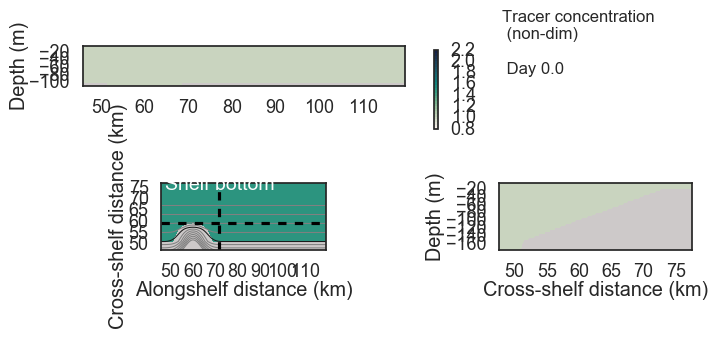

In [103]:
# frames for beamer animation

cmap_name = cmo.cm.tempo
cmap_name2 = cmo.cm.tempo
sns.set_context('talk')
sns.set_style('white')

plt.rcParams['font.size'] = 14.0


starttime = 0
data = ConcFilt[starttime,yslice_bac,xslice]
data_all_times = ConcFilt[:,yslice_bac,xslice]


#fig = plt.figure()
f = plt.figure(figsize = (7.4,3)) # 19.0cm = 7.4in, 115cm = 4.52in
   
for tt in range(1):
    
    next_frame(tt)
    frame_name2 = ('/ocean/kramosmu/Figures/PoolHighConcentration/BottomConc_basecaseNorm_tt%02d.png' %tt) 
    plt.savefig(frame_name2,  format='png')



In [21]:
import matplotlib.animation as animation
print(animation.writers.list())

['avconv_file', 'ffmpeg', 'imagemagick', 'ffmpeg_file', 'imagemagick_file', 'avconv']


/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


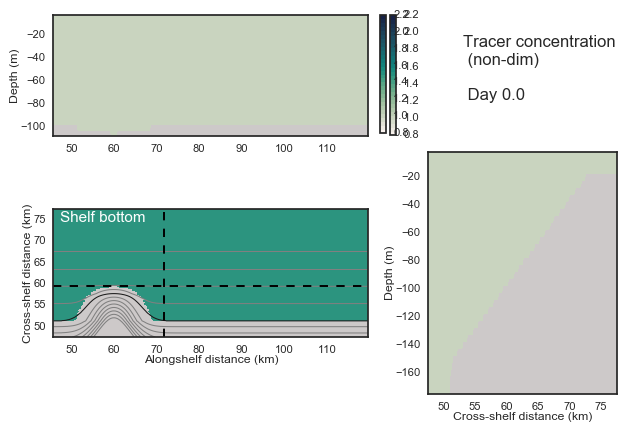

In [16]:
dpi=300
fig = plt.figure(figsize=(12,14),dpi=dpi)

cmap_name = cmo.cm.tempo
cmap_name2 = cmo.cm.tempo
sns.set_context('paper')
sns.set_style('white')

plt.rcParams['font.size'] = 11.0


gs0 = gspec.GridSpec(2, 2, height_ratios=[0.5,1], width_ratios=[1,0.6])

trmax = 8
trmin=-8

starttime = 0
data = ConcFilt[starttime,yslice_bac,xslice]
data_all_times = ConcFilt[:,yslice_bac,xslice]

fig = plt.figure()
 
def init():
    next_frame(0)
 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1.2, metadata=dict(artist='Me'), bitrate=-1)
anim = animation.FuncAnimation(fig, next_frame,init_func=init, frames=19,repeat=False)
anim.save('Oxygen_anom.mp4',writer=writer)


In [71]:
def next_frameAnom(t):

    timeIndex = starttime + t 
    data = ConcFilt[timeIndex,yslice_bac,xslice]
    gs0 = gspec.GridSpec(2, 2, height_ratios=[0.5,1], width_ratios=[1,0.6])

    Plot1anom(gs0[0,0],t,ptracers.Tr03.isel(Y=yind),ptracersNoC.Tr03.isel(Y=yind),
              zslice,267,xslice,Trmin=-0.4,Trmax=0.4) # x-z contours conc

    Plot2anom(gs0[1,1],t,ptracers.Tr03.isel(X=xind),ptracersNoC.Tr03.isel(X=xind),
              yslice_bac,zslice_2,250,Trmin=-0.4,Trmax=0.4) # bottom concentration

    Plot3anom(gs0[1,0],t,np.ma.masked_array(ConcFilt,mask=maskExpandSB),np.ma.masked_array(ConcFiltNoC,mask=maskExpandSB),
              xslice,yslice_bac,250,267,-0.4,0.4)

    plt.tight_layout()


0
1


/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


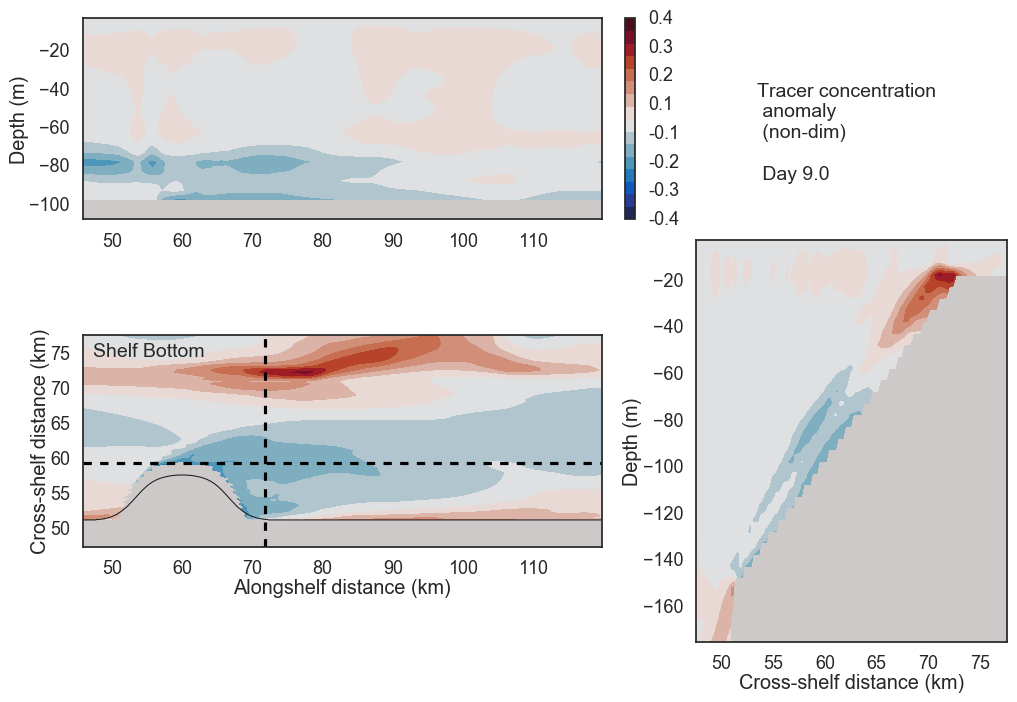

In [76]:
cmap_name = cmo.cm.balance
sns.set_context('talk')
sns.set_style('white')

plt.rcParams['font.size'] = 14.0


gs0 = gspec.GridSpec(2, 2, height_ratios=[0.6,1], width_ratios=[1,0.6])

trmax = 8
trmin=-8

starttime = 0

fig = plt.figure()
    
for tt in range(19):
    print(tt)
    next_frameAnom(tt)
    frame_name2 = ('/ocean/kramosmu/Figures/PoolHighConcentration/BottomConcAnomNorm_oxygen_tt%02d.png' %tt) 
    plt.savefig(frame_name2,  format='png')



0
0


/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18


0
0


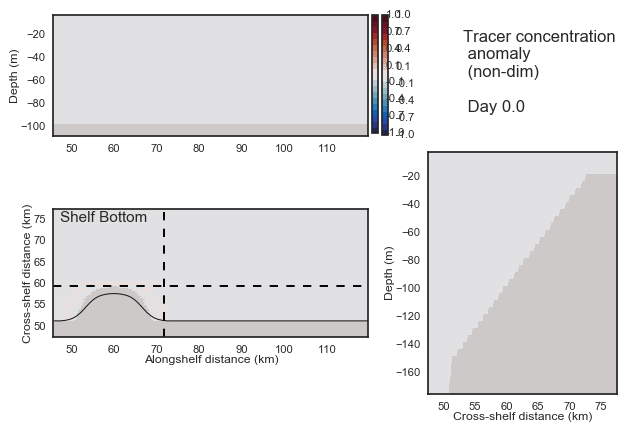

In [22]:
dpi=300
fig = plt.figure(figsize=(12,14),dpi=dpi)

cmap_name = cmo.cm.balance
sns.set_context('paper')
sns.set_style('white')

plt.rcParams['font.size'] = 11.0


gs0 = gspec.GridSpec(2, 2, height_ratios=[0.5,1], width_ratios=[1,0.6])

trmax = 8
trmin=-8

starttime = 0

fig = plt.figure()
 
def init():
    next_frameAnom(0)
 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1.2, metadata=dict(artist='Me'), bitrate=-1)
anim = animation.FuncAnimation(fig, next_frameAnom,init_func=init, frames=19,repeat=False)
anim.save('oxygen_anom.mp4',writer=writer)
